In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UBC-OCEAN/updated_image_ids.json
/kaggle/input/UBC-OCEAN/sample_submission.csv
/kaggle/input/UBC-OCEAN/train.csv
/kaggle/input/UBC-OCEAN/test.csv
/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png
/kaggle/input/UBC-OCEAN/train_images/14127.png
/kaggle/input/UBC-OCEAN/train_images/34649.png
/kaggle/input/UBC-OCEAN/train_images/15221.png
/kaggle/input/UBC-OCEAN/train_images/52375.png
/kaggle/input/UBC-OCEAN/train_images/17487.png
/kaggle/input/UBC-OCEAN/train_images/32112.png
/kaggle/input/UBC-OCEAN/train_images/22290.png
/kaggle/input/UBC-OCEAN/train_images/48734.png
/kaggle/input/UBC-OCEAN/train_images/39146.png
/kaggle/input/UBC-OCEAN/train_images/64950.png
/kaggle/input/UBC-OCEAN/train_images/32042.png
/kaggle/input/UBC-OCEAN/train_images/63429.png
/kaggle/input/UBC-OCEAN/train_images/13526.png
/kaggle/input/UBC-OCEAN/train_images/53859.png
/kaggle/input/UBC-OCEAN/train_images/63836.png
/kaggle/input/UBC-OCEAN/train_images/56117.png
/kaggle/input/UBC-OCEAN/train_i

# Import Libraries

In [2]:
import time
import cv2 as cv
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Dense, MaxPooling2D, Input, Dropout, Conv2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import keras
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.optimizers import Adam, SGD
from keras.utils import plot_model

# Load dataset

In [5]:
train = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
train.head() 

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [6]:
# is_ma = True
istma_False = train[train["is_tma"]==False]
istma_False.tail()

,image_id,label,image_width,image_height,is_tma
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False
537,65533,HGSC,45190,33980,False


In [7]:
test = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')
test.head()

,image_id,image_width,image_height
0,41,28469,16987


In [8]:
train['label'].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

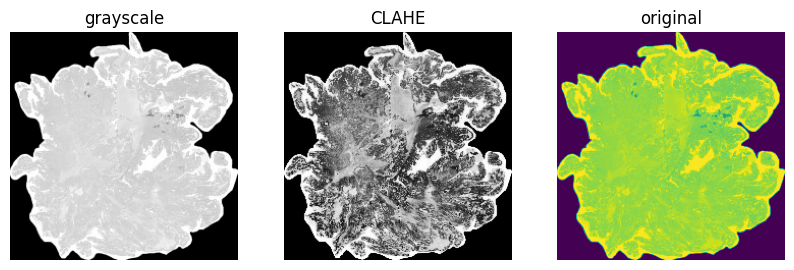

In [9]:
# Sample images for plotting
path = "/kaggle/input/UBC-OCEAN/train_thumbnails/65371_thumbnail.png"
image_org = cv.imread(path)
image = cv.imread(path, 0)
image = cv.resize(image, (224, 224), interpolation=cv.INTER_AREA)

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2, 2))
clahe_img = clahe.apply(image)

#  Plotting
fig, ax = plt.subplots(1,3, figsize=(10,7))
ax[0].imshow(image, cmap='gray'),ax[0].set_title('grayscale'), ax[0].axis('off')
ax[1].imshow(clahe_img, cmap='gray'), ax[1].set_title('CLAHE'), ax[1].axis('off')
ax[2].imshow(image), ax[2].set_title('original'), ax[2].axis('off')
plt.show()

In [10]:
def preprocessing(path):
    image = cv.imread(path, 0)
    image = cv.resize(image, (224, 224), interpolation = cv.INTER_AREA)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2,2))
    clahe_img = clahe.apply(image)
    
    
    w,h = clahe_img.shape
    rgb_img = np.zeros((w,h,3), dtype=np.uint8)
    rgb_img[:,:,0] = clahe_img
    rgb_img[:,:,1] = clahe_img
    rgb_img[:,:,2] = clahe_img
            
    return rgb_img

In [11]:
def data_img(dataframe, path):
    classes = []
    images = []
    for data in dataframe.iterrows():
        img_path = os.path.join(path,f"{str(data[1][0])}_thumbnail.png")
        
        classes.append(data[1][1])
        images.append(preprocessing(img_path))
       
    # Encode classes
    le = LabelEncoder()
    label = le.fit_transform(classes)
    label_list = list(le.classes_)
        
    return images, label, label_list

In [12]:
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
images, label, label_list = data_img(istma_False, path)

images = np.array(images)
print(images.shape)

/tmp/ipykernel_48/278942310.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(path,f"{str(data[1][0])}_thumbnail.png")
/tmp/ipykernel_48/278942310.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes.append(data[1][1])


(513, 224, 224, 3)


# splitting Training and testing images

In [13]:
images = np.array(images)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_data = datagen.flow(
    X_train,
    y=y_train,
    batch_size = 32)

In [14]:
test_data = datagen.flow(
    X_test,
    y=y_test,
    batch_size = 32)

# Model Develop

# Single model - VGG19
 # Pretrained on imagenet dataset
 # All layers , Further trainable

# Build VGG19

In [15]:
base_model = VGG19(
     include_top = False,
     input_shape = (224,224,3),
    weights = 'imagenet'
)

80134624/80134624 [==============================] - 1s 0us/step


In [16]:
num_classes = 5

In [17]:
for layer in base_model.layers:
    layer.trainable = True

In [18]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [20]:
filepath = "bench_mark_-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [21]:
history = model.fit(
    train_data,
    validation_data  = test_data ,
    epochs = 10,
    callbacks=[reduce_lr,early_stopping,checkpoint]
)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 10.5944 - accuracy: 0.3512
Epoch 1: val_accuracy improved from -inf to 0.38835, saving model to bench_mark_-model-01-0.39.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 36s 1s/step - loss: 10.5944 - accuracy: 0.3512 - val_loss: 1.4921 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.4243 - accuracy: 0.4317
Epoch 2: val_accuracy did not improve from 0.38835
13/13 [==============================] - 6s 483ms/step - loss: 1.4243 - accuracy: 0.4317 - val_loss: 1.5289 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.4276 - accuracy: 0.4220
Epoch 3: val_accuracy did not improve from 0.38835
13/13 [==============================] - 6s 489ms/step - loss: 1.4276 - accuracy: 0.4220 - val_loss: 1.4959 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.4225 - accuracy: 0.4317
Epoch 4: val_accuracy did not improve from 0.38835
13/13 [==============================] - 6s 495ms/step - loss: 1.4225 - accuracy: 0.4317 - val_loss: 1.5074 - val_accuracy: 0.3883 - l

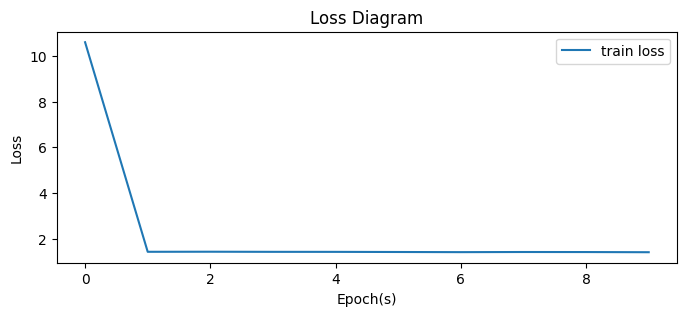

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
#plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 1s 792ms/step


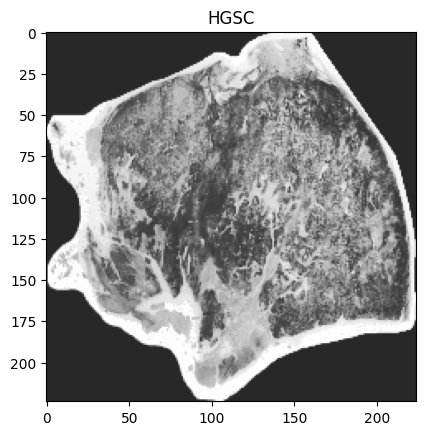

In [23]:
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = preprocessing(test_path)
img_array = np.expand_dims(image,0)
classes = model.predict(img_array/255)

plt.imshow(image, cmap='gray')
plt.title(label_list[np.argmax(classes)])
plt.show()

# Build ResNet50

In [24]:
base_model = ResNet50(
     include_top = False,
     input_shape = (224,224,3),
    weights = 'imagenet'
)

94765736/94765736 [==============================] - 0s 0us/step


In [25]:
num_classes = 5

In [26]:
for layer in base_model.layers:
    layer.trainable = True

In [27]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [29]:
filepath = "bench_mark_-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [30]:
history = model.fit(
    train_data,
    validation_data  = test_data ,
    epochs = 10,
    callbacks=[reduce_lr,early_stopping,checkpoint]
)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.6680 - accuracy: 0.3561
Epoch 1: val_accuracy improved from -inf to 0.38835, saving model to bench_mark_-model-01-0.39.hdf5
13/13 [==============================] - 50s 852ms/step - loss: 1.6680 - accuracy: 0.3561 - val_loss: 6.9760 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.3684 - accuracy: 0.4634
Epoch 2: val_accuracy did not improve from 0.38835
13/13 [==============================] - 5s 381ms/step - loss: 1.3684 - accuracy: 0.4634 - val_loss: 27.4503 - val_accuracy: 0.2136 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.5610
Epoch 3: val_accuracy did not improve from 0.38835
13/13 [==============================] - 5s 385ms/step - loss: 1.1033 - accuracy: 0.5610 - val_loss: 2.5800 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.0001 - accur

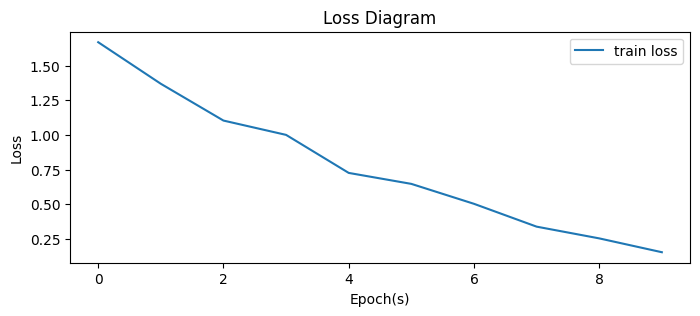

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
#plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


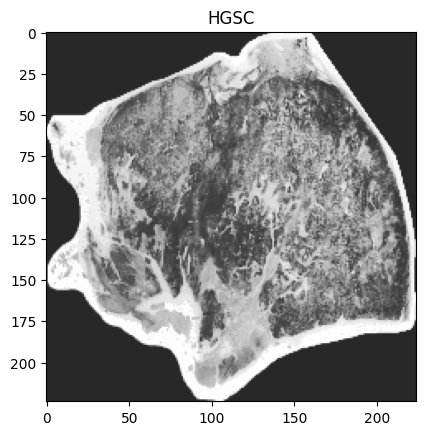

In [32]:
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = preprocessing(test_path)
img_array = np.expand_dims(image,0)
classes = model.predict(img_array/255)

plt.imshow(image, cmap='gray')
plt.title(label_list[np.argmax(classes)])
plt.show()

# ResNet50

In [33]:
base_model = ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

In [34]:
for layer in base_model.layers:
    layer.trainable = False

In [35]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [37]:
filepath = "bench_mark_-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [38]:
history = model.fit(
    train_data,
    validation_data  = test_data ,
    epochs = 10,
    callbacks=[reduce_lr,early_stopping,checkpoint]
)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.6998 - accuracy: 0.3732
Epoch 1: val_accuracy improved from -inf to 0.38835, saving model to bench_mark_-model-01-0.39.hdf5
13/13 [==============================] - 7s 273ms/step - loss: 1.6998 - accuracy: 0.3732 - val_loss: 1.8300 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.4268
Epoch 2: val_accuracy did not improve from 0.38835
13/13 [==============================] - 2s 137ms/step - loss: 1.4891 - accuracy: 0.4268 - val_loss: 1.5756 - val_accuracy: 0.2816 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.3768 - accuracy: 0.4415
Epoch 3: val_accuracy did not improve from 0.38835
13/13 [==============================] - 2s 136ms/step - loss: 1.3768 - accuracy: 0.4415 - val_loss: 1.4818 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.3703 - accurac

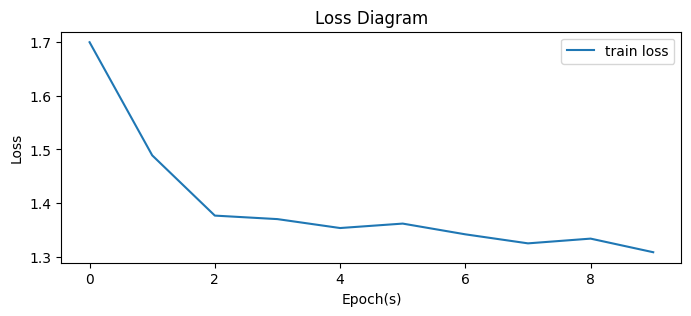

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
#plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


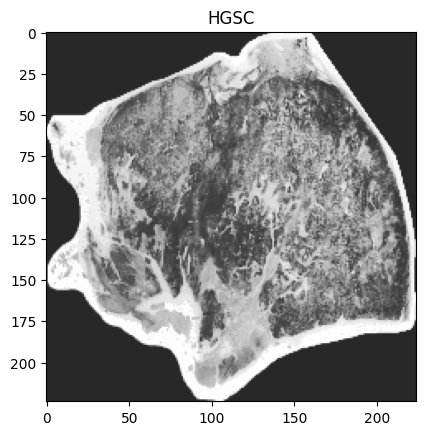

In [40]:
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = preprocessing(test_path)
img_array = np.expand_dims(image,0)
classes = model.predict(img_array/255)

plt.imshow(image, cmap='gray')
plt.title(label_list[np.argmax(classes)])
plt.show()

#  Build InceptionV3

In [41]:
base_model = InceptionV3(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

87910968/87910968 [==============================] - 0s 0us/step


In [42]:
for layer in base_model.layers:
    layer.trainable = True

In [43]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [45]:
filepath = "bench_mark_-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [46]:
history = model.fit(
    train_data,
    validation_data  = test_data ,
    epochs = 10,
    callbacks=[reduce_lr,early_stopping,checkpoint]
)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.5131 - accuracy: 0.3854
Epoch 1: val_accuracy improved from -inf to 0.38835, saving model to bench_mark_-model-01-0.39.hdf5
13/13 [==============================] - 52s 924ms/step - loss: 1.5131 - accuracy: 0.3854 - val_loss: 76.3300 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.4387 - accuracy: 0.4171
Epoch 2: val_accuracy did not improve from 0.38835
13/13 [==============================] - 3s 264ms/step - loss: 1.4387 - accuracy: 0.4171 - val_loss: 8431.6816 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.4293
Epoch 3: val_accuracy did not improve from 0.38835
13/13 [==============================] - 3s 267ms/step - loss: 1.3877 - accuracy: 0.4293 - val_loss: 9662.2354 - val_accuracy: 0.1262 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.2663 -

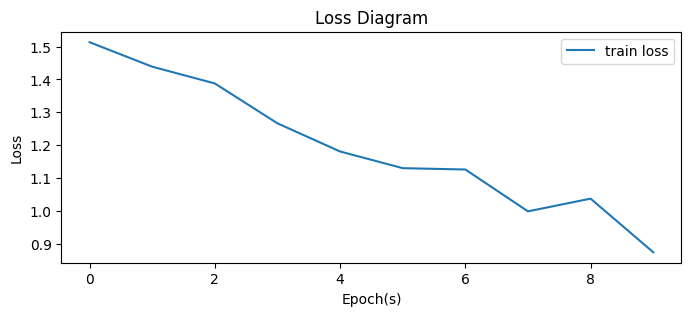

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
#plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 2s 2s/step


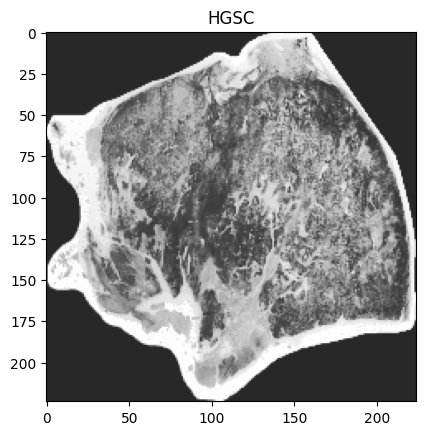

In [48]:
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = preprocessing(test_path)
img_array = np.expand_dims(image,0)
classes = model.predict(img_array/255)

plt.imshow(image, cmap='gray')
plt.title(label_list[np.argmax(classes)])
plt.show()

# Ensemble Model

In [49]:
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate
from keras.models import Model
from keras.applications import ResNet50, VGG19, InceptionV3
from keras.preprocessing import image


def build_resnet50_path(input_image):
    #x = resnet50_preprocess_input(input_tensor)
    base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_image)
    for layer in base_resnet50.layers:
        layer.trainable = True
    path = GlobalAveragePooling2D()(base_resnet50.output)
    return path
def build_vgg19_path(input_image):
    #x = vgg19_preprocess_input(input_tensor)
    base_vgg19 = VGG19(weights='imagenet', include_top=False, input_tensor=input_image)
    for layer in base_vgg19.layers:
        layer.trainable = True
    path = GlobalAveragePooling2D()(base_vgg19.output)
    return path

def build_inception_path(input_image):
    #x = inception_preprocess_input(input_tensor)
    base_inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_image)
    for layer in base_inception.layers:
        layer.trainable = True
    path = GlobalAveragePooling2D()(base_inception.output)
    return path
def build_ensemble_model():
    num_classes =5

    input_image1 = Input(shape=(224, 224, 3), name='input_image1')
    #input_shape = (224, 224, 3)
    #input_tensor = Input(shape=input_shape)

    path_resnet50 = build_resnet50_path(input_image1)
    path_vgg19 = build_vgg19_path(input_image1)
    path_inception = build_inception_path(input_image1)

    concatenated_features = concatenate([path_resnet50, path_vgg19, path_inception])
    x = Dense(256, activation='relu')(concatenated_features)
   # x = Dense(32, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    ensemble_model = Model(inputs=input_image1, outputs=output)

    ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return ensemble_model

# Build the ensemble model
model_en = build_ensemble_model()

# Display the model summary
model_en.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image1 (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_image1[0][0]']        
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [50]:
model_en.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [51]:
filepath = "bench_mark_-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [52]:
history = model_en.fit(
    train_data,
    validation_data  = test_data ,
    epochs = 10,
    callbacks=[reduce_lr,early_stopping,checkpoint]
)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 17.2272 - accuracy: 0.3415
Epoch 1: val_accuracy improved from -inf to 0.38835, saving model to bench_mark_-model-01-0.39.hdf5
13/13 [==============================] - 95s 2s/step - loss: 17.2272 - accuracy: 0.3415 - val_loss: 23018.9980 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.4252 - accuracy: 0.4122
Epoch 2: val_accuracy did not improve from 0.38835
13/13 [==============================] - 15s 1s/step - loss: 1.4252 - accuracy: 0.4122 - val_loss: 53910.9180 - val_accuracy: 0.1262 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.2325 - accuracy: 0.5024
Epoch 3: val_accuracy did not improve from 0.38835
13/13 [==============================] - 16s 1s/step - loss: 1.2325 - accuracy: 0.5024 - val_loss: 39616.9961 - val_accuracy: 0.1456 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.0998 -

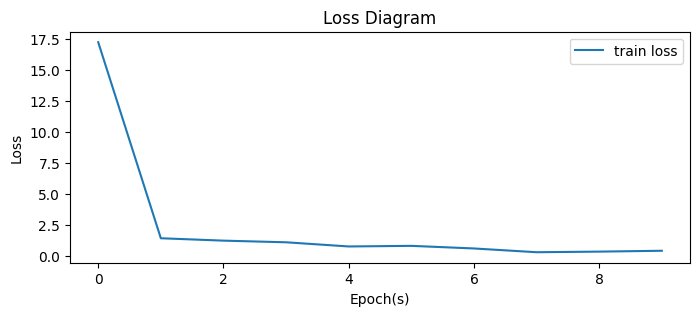

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
#plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 34ms/step


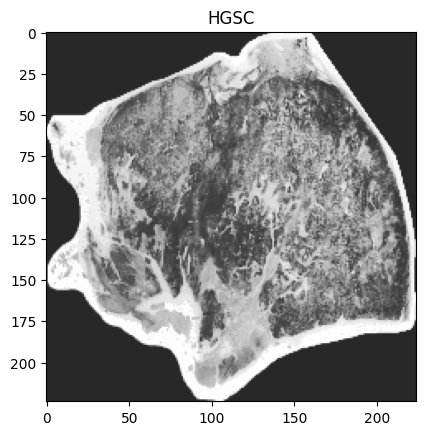

In [54]:
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = preprocessing(test_path)
img_array = np.expand_dims(image,0)
classes = model.predict(img_array/255)

plt.imshow(image, cmap='gray')
plt.title(label_list[np.argmax(classes)])
plt.show()

# Vision Transformer

In [55]:
!pip install -U tensorflow-addons

  Obtaining dependency information for tensorflow-addons from https://files.pythonhosted.org/packages/c0/a0/2bb2edb863555eb87e8ed45ded678138f454743a6ee90e0ee994f00a7147/tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.22.0
    Uninstalling tensorflow-addons-0.22.0:
      Successfully uninstalled tensorflow-addons-0.22.0


In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [57]:
num_classes = 5
input_shape = (224, 224, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [58]:
#split dataset

images = np.array(images)
x_train, x_test, y_train, y_test = train_test_split(images, label, test_size=0.2,random_state=42)

In [59]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [60]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [61]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [62]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [63]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [64]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [65]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
2/2 [==============================] - 14s 2s/step - loss: 10.6276 - accuracy: 0.2358 - top-5-accuracy: 1.0000 - val_loss: 8.7027 - val_accuracy: 0.1707 - val_top-5-accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 8.0899 - accuracy: 0.3089 - top-5-accuracy: 1.0000 - val_loss: 2.9163 - val_accuracy: 0.1951 - val_top-5-accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 241ms/step - loss: 2.7534 - accuracy: 0.3442 - top-5-accuracy: 1.0000 - val_loss: 1.8517 - val_accuracy: 0.1463 - val_top-5-accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 2s 2s/step - loss: 2.2567 - accuracy: 0.2466 - top-5-accuracy: 1.0000 - val_loss: 1.7270 - val_accuracy: 0.3902 - val_top-5-accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 241ms/step - loss: 1.8503 - accuracy: 0.3577 - top-5-accuracy: 1.0000 - val_loss: 1.7776 - val_accuracy: 0.2927 - val_top-5-accuracy: 1.0000
Epoch 6/10
2/2 [=====================

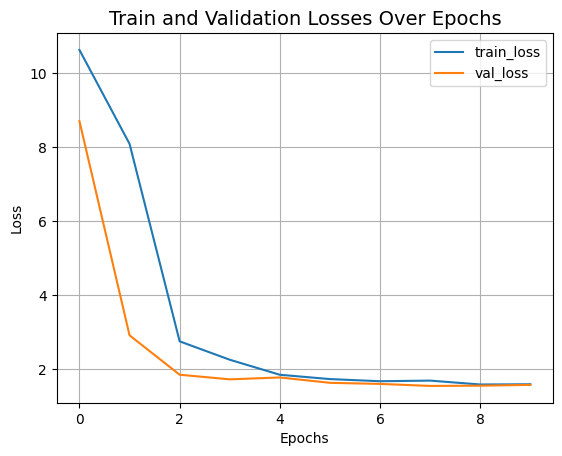

In [66]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

# SWIN  Transformer

In [67]:
#split dataset

images = np.array(images)
x_train, x_test, y_train, y_test = train_test_split(images, label, test_size=0.2,random_state=42)

In [68]:
num_classes = 5
input_shape = (224, 224, 3)

In [69]:
patch_size = (4, 4)  # 4-by-4 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 224  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 10
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [70]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [71]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [72]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [73]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [74]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [75]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.Normalization()(x)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [76]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/10
12/12 [==============================] - 7s 270ms/step - loss: 123.9829 - accuracy: 0.2629 - top-5-accuracy: 1.0000 - val_loss: 125.7743 - val_accuracy: 0.1707 - val_top-5-accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 2s 188ms/step - loss: 81.6000 - accuracy: 0.3225 - top-5-accuracy: 1.0000 - val_loss: 34.5789 - val_accuracy: 0.3902 - val_top-5-accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 2s 190ms/step - loss: 27.1729 - accuracy: 0.2629 - top-5-accuracy: 1.0000 - val_loss: 15.8307 - val_accuracy: 0.3902 - val_top-5-accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 2s 190ms/step - loss: 14.8306 - accuracy: 0.2981 - top-5-accuracy: 1.0000 - val_loss: 8.1481 - val_accuracy: 0.3171 - val_top-5-accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 2s 191ms/step - loss: 11.6495 - accuracy: 0.2791 - top-5-accuracy: 1.0000 - val_loss: 17.6547 - val_accuracy: 0.3902 - val_top-5-accuracy: 1.0000
Epoch 6/1

In [77]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

4/4 [==============================] - 0s 47ms/step - loss: 14.5124 - accuracy: 0.1942 - top-5-accuracy: 1.0000
Test loss: 14.51
Test accuracy: 19.42%
Test top 5 accuracy: 100.0%


1/1 [==============================] - 1s 765ms/step


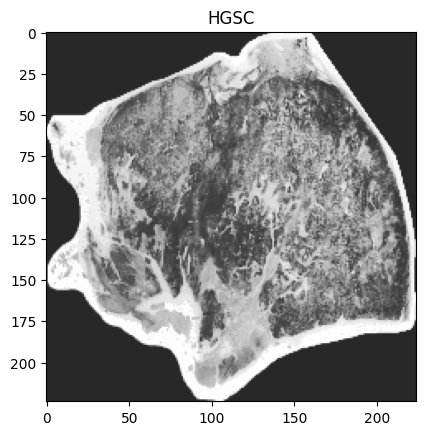

In [78]:
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = preprocessing(test_path)
img_array = np.expand_dims(image,0)
classes = model.predict(img_array/255)

plt.imshow(image, cmap='gray')
plt.title(label_list[np.argmax(classes)])
plt.show()

In [79]:
data = pd.read_csv("/kaggle/input/UBC-OCEAN/sample_submission.csv")
data.head()

,image_id,label
0,41,HGSC


In [80]:
data.loc[0,'label']='CC'

In [81]:
data.head() 

,image_id,label
0,41,CC


In [82]:
data.to_csv("submission.csv")